# Selection et entrainement des modèles 

***Résumé Exécutif du Feature Engineering - Prévision Solaire J+1***

L'étape de feature_engineering a consisté à la prise en compte des conclusions de l'analyse exploratoire (EDA), ainsi que la création de garde-fous données manquantes/outliers ainsi que la création de features cycliques et de variables laggées.

**Données** : Dataset horaire sur 2.5 ans (01/2023 - 05/2025) de production RTE et prévisions OpenMétéo. Identification de 2 valeurs manquantes nocturnes dans la cible, qui seront imputées à 0.

**Gardes-fous :**
- Création de tests IQR/Z-score et raise des outliers en intersection des deux filtres ;
- Interpolation des séquences temporelles inférieures à 3h consécutives ;
- Lors d'une absence de séquence de plus de 3 heures, création d'un reporting des séquences les plus longues, et potentiellement création d'un futur algorithme KNN - Filtre de Kalman.

**Features créées :**
- Création de features cycliques heures + mois, en fonction de la saisonnalité du cycle solaire ;
- Création de features laggées (data leakage évité): 
  - Retard de 24, 32 et 48 (observation des cross-correlation + cohérent physiquement) ;
  - Moyennes mobiles de 24, 32 et 48 périodes (analogue aux features retard).
 
**Etapes effectuées dans ce notebook** :

- Transformations statistiques pour les données LSTM et/ou SARIMAX si nécessaire ;
- Baseline SARIMAX avec les features physiques les plus corrélées ;
- Sélection de features (Embedding via LightGBM) ;
- Validation croisée "Expanding Window" avec optimisation des hyperparamètres (Optuna) ;
- Développement de modèles LightGBM et LSTM, avec MC dropout et regression quantile pour quantifier l'incertitude des modèles.

### Import des librairies

In [1]:
# import librairies modèles
import pandas as pd
from supabase import Client, create_client
import torch.nn as nn
import torch
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import optuna
import lightgbm as lgb
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
import plotly.express as px
from tqdm import tqdm

#Logs, typing
from typing import Optional, Dict
import traceback
import logging

d:\Anaconda\envs\solar_forecasting\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Préparation des datasets d'entrainement

In [4]:
import os
os.chdir("D:/Objectif master/Projects/solar_forecasting/solar_prediction")

In [5]:
df = pd.read_csv("data/processed/df_engineered.csv", index_col=0)
df.index = pd.to_datetime(df.index, utc=True).tz_convert("Europe/Paris")
df_power = pd.read_csv("data/processed/occitanie_installed_power.csv", index_col=0, parse_dates=True)
df_power.index = pd.to_datetime(df_power.index, utc=True).tz_convert("Europe/Paris")

## Préparation des jeux de validation croisée
La validation croisée (CV) est primordiale, non seulement pour trouver les hyperparamètres optimaux sur plusieurs datasets de validation, mais aussi pour sélectionner les modèles entre eux dans des conditions pseudo-réelles, avec la validation croisée imbriquée (nested CV). Pour l'optimisation des hyperparamètres dans chaque fold, nous utiliserons l'alogrithme TPE supporté par Optuna.

In [1]:
def outer_time_series_fold(X: pd.DataFrame, y: pd.Series, outer_n_splits: int = 5):
    """Effectue une validation croisée externe avec TimeSeriesSplit"""

    dict_outer_fold = {}
    tscv = TimeSeriesSplit(gap=0, n_splits=outer_n_splits)

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        dict_outer_fold[f'train_{i}'] = [X_train, y_train]
        dict_outer_fold[f'val_{i}'] = [X_test, y_test]
    
    return dict_outer_fold

NameError: name 'pd' is not defined

In [16]:
def inner_time_series_fold(folds: dict, inner_n_splits : int = 3):
    """Effectue une validation croisée interne (nested CV) sur les folds d'entraînement"""
    
    dict_inner_fold = {}
    tscv = TimeSeriesSplit(gap=0, n_splits=inner_n_splits)

    for key, (X_train_outer, y_train_outer) in folds.items():
        
        if key.startswith("train"):
            
            for inner_i, (train_index, test_index) in enumerate(tscv.split(X_train_outer)):
                X_train_inner, X_val_inner = X_train_outer.iloc[train_index], X_train_outer.iloc[test_index]
                y_train_inner, y_val_inner = y_train_outer.iloc[train_index], y_train_outer.iloc[test_index]
                dict_inner_fold[f'{key}_inner_train_{inner_i}'] = [X_train_inner, y_train_inner]
                dict_inner_fold[f'{key}_inner_val_{inner_i}'] = [X_val_inner, y_val_inner]
    
    return dict_inner_fold

## Modèle SARIMAX

Le modèle SARIMAX est un modèle statistique qui servira de baseline de performance aux autres modèles.

In [ ]:
def train_sarimax(X_train: pd.DataFrame, 
                   y_train: pd.Series, 
                   X_val: pd.DataFrame, 
                   y_val: pd.Series, 
                   num_trials: Optional[int|None]) -> tuple:
    
    """Entrainement d'un modèle SARIMAX avec nombre d'essais pour optimisation.
    Retourne la quantification de son erreur (best_rmse) et ses hyperparamètres 
    optimaux (dict_best_params) sur un dataset de validation (X_val, y_val)

    Args:
        X_train (pd.DataFrame): Dataset d'entrainement
        y_train (pd.Series): Variable cible d'entrainement
        X_val (pd.DataFrame): Dataset de validation
        y_val (pd.Series): Variable cible de validation

    Returns:
        best_rmse (float), dict_best_params (Dict) : Erreur (best_rmse) 
        et ses hyperparamètres optimaux (dict_best_params)
    """
    # Initialisation
    best_rmse = np.inf
    dict_best_params = {}
    
    def objective_sarimax(trial) -> np.float64 :
        """Prend en entrée un set d'hyperparamètres SARIMAX issus du sampler d'Optuna, 
        et retourne le RMSE associé.

        Args:
            trial : Set d'hyperparamètres SARIMAX

        Returns:
            rmse (np.float64): Racine carrée de l'erreur quadratique moyenne du modèle
        """
        # HP
        d = 0
        s = 24

        order = (trial.suggest_int("p", 0, 3), 
                d, 
                trial.suggest_int("q", 0, 3))
        
        seasonal_order = (trial.suggest_int("P", 0, 2), 
                          trial.suggest_int("D", 0, 1), 
                          trial.suggest_int("D", 0, 1), s)

        # Model
        model = SARIMAX(endog=y_train, 
                            exog=X_train, 
                            order = order, 
                            seasonal_order = seasonal_order)
        
        # Training
        try:
            fitted_model = model.fit(disp=False, maxiter=100)
            predictions = fitted_model.get_prediction(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, predictions))
        
        except Exception as e:
            logging.info("Echec de l'entrainement du modèle%s", e)
            logging.debug("Détails complets :\n%s", traceback.format_exc())
            raise

        return rmse


    # Recherche des HP et prédictions
    try:
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_sarimax, n_trials=num_trials, n_jobs=4)
    
    except Exception as e:
        logging.error(
        "Échec de la recherche d’HP. Paramètres : n_trials=%d, n_jobs=%d. Erreur : %s",
        num_trials, 4, str(e),
        exc_info=True)
        raise
    
    # Set optimal score/HP
    dict_best_params = study.best_params
    best_rmse = study.best_value

    return best_rmse, dict_best_params

In [ ]:
def inner_cv_sarimax(outer_id: int, inner_folds: Dict, num_trials: int, inner_n_splits: int) -> Dict:
    
    """Renvoie la liste optimale d'HP en effectuant une cross_validation interne 
    sur le fold (outer_id), avec un nombre d'essais (num_trials)

    Args:
        outer_id (int): ID du fold externe étudié
        inner_folds (Dict): Folds internes
        num_trials (int): Nombre d'essais Optuna
        inner_n_split (int): Nombre de split dans tes outer splits

    Returns:
        fold_best_params (Dict) : Liste optimale d'HP pour le fold outer_id
    """

    #Initialisation
    inner_scores = []
    inner_params = []
    n_folds = inner_n_splits

    # CV interne
    for inner_id in range(n_folds):
        X_train_inner, y_train_inner = inner_folds[f'train_{outer_id}_inner_train_{inner_id}']
        X_val_inner, y_val_inner = inner_folds[f'train_{outer_id}_inner_val_{inner_id}']

        best_rmse, best_params = train_sarimax(X_train=X_train_inner, 
                                                y_train=y_train_inner, 
                                                X_val=X_val_inner, 
                                                y_val=y_val_inner,
                                                num_trials=num_trials)
        # Scoring sur la CV interne
        inner_scores.append(best_rmse)
        inner_params.append(best_params)

    # HP optimaux pour le outer fold concerné
    best_inner_idx = np.argmin(inner_scores)
    fold_best_params = inner_params[best_inner_idx]

    return fold_best_params

In [ ]:
def nested_cv_sarimax(X: pd.DataFrame,
                      y: pd.Series,
                      num_trials: int,
                      outer_n_splits: int = 5,
                      inner_n_splits: int = 3) -> tuple:
    
    """Renvoie le RMSE moyen de l'ensemble des folds sur un modèle SARIMAX,
    avec recherche d'hyperparamètres par nested CV.

    Args:
        X (pd.DataFrame): Variables explicatives
        y (pd.Series): Variable cible
        num_trials (int): Nombre d'essais Optuna pour l'optimisation
        outer_n_splits (int): Nombre de splits externes
        inner_n_splits (int): Nombre de splits internes

    Returns:
        tuple: (outer_scores, mean_outer_score)
            - outer_scores : Liste des RMSE par fold externe
            - mean_outer_score : Moyenne des RMSE externes
    """
    # Création des folds externes et internes
    outer_folds = outer_time_series_fold(X, y, outer_n_splits=outer_n_splits)
    inner_folds = inner_time_series_fold(outer_folds, inner_n_splits=inner_n_splits)
    outer_scores = []

    for outer_id in range(outer_n_splits):
        
        # Séparation train/val externe
        X_train_outer, y_train_outer = outer_folds[f"train_{outer_id}"]
        X_val_outer, y_val_outer = outer_folds[f"val_{outer_id}"]

        # Sélection des meilleurs hyperparamètres via inner CV
        fold_best_params = inner_cv_sarimax(
            outer_id=outer_id,
            inner_folds=inner_folds,
            num_trials=num_trials,
            inner_n_splits=inner_n_splits
        )

        # Instanciation du meilleur modèle SARIMAX
        best_model = SARIMAX(
            endog=y_train_outer,
            exog=X_train_outer,
            order=fold_best_params["order"],
            seasonal_order=fold_best_params.get("seasonal_order", (0, 0, 0, 0)),
        )

        # Fit du modèle
        fitted_model = best_model.fit(disp=False)

        # Prédiction sur la validation externe
        y_pred_outer = fitted_model.get_prediction(
            start=y_val_outer.index[0],
            end=y_val_outer.index[-1],
            exog=X_val_outer
        )

        # Calcul du RMSE externe
        outer_rmse = np.sqrt(mean_squared_error(y_val_outer, y_pred_outer))
        outer_scores.append(outer_rmse)

    # Moyenne des scores externes
    mean_outer_score = np.mean(outer_scores)
    logging.info(f'RMSE global moyen attendu en production : {mean_outer_score}')

    return outer_scores, mean_outer_score

In [ ]:
# A lancer
feature_sarimax = ['temperature_2m', 'relative_humidity_2m', 'precipitation',
       'surface_pressure', 'cloud_cover', 'wind_speed_10m',
       'wind_direction_10m', 'global_tilted_irradiance',
       'global_tilted_irradiance_delta_minmax', 'global_tilted_irradiance_std'] 

X = df[feature_sarimax]
y = df["solar_mw"]

outer_n_splits = 5
inner_n_splits = 2
num_trials = 10
outer_scores, mean_outer_score = nested_cv_sarimax(X=X, 
                                                    y=y, 
                                                    num_trials=num_trials, 
                                                    outer_n_splits=outer_n_splits, 
                                                    inner_n_splits=inner_n_splits)

## Modèle LightGBM

Le modèle LightGBM est un modèle par arbre qui est particulièrement intéressant dans le cadre de la compréhension de données bruitées et des interactions non linéaires. Nous pourrions aussi le comparer à XGBoost, qui a la faculté d'éviter plus souvent l'overfitting (à plus long terme). Le RMSE sera pris comme métrique de minimisation pour permettre une meilleure prise en compte des évènements extrêmes. Le MAE, MAPE et SMAPE seront aussi retournés, cette fois à titre indicatif pour comparaison.

In [17]:
def train_lightgbm(X_train: pd.DataFrame, 
                   y_train: pd.Series, 
                   X_val: pd.DataFrame, 
                   y_val: pd.Series, 
                   num_trials: Optional[int|None]) -> tuple:
    
    """Entrainement d'un modèle LightGBM avec nombre d'essais pour optimisation.
    Retourne la quantification de son erreur (best_rmse) et ses hyperparamètres 
    optimaux (dict_best_params) sur un dataset de validation (X_val, y_val)

    Args:
        X_train (pd.DataFrame): Dataset d'entrainement
        y_train (pd.Series): Variable cible d'entrainement
        X_val (pd.DataFrame): Dataset de validation
        y_val (pd.Series): Variable cible de validation

    Returns:
        best_rmse (float), dict_best_params (Dict) : Erreur (best_rmse) 
        et ses hyperparamètres optimaux (dict_best_params)
    """
    # Initialisation
    best_rmse = np.inf
    dict_best_params = {}
    
    def objective_lightgbm(trial) -> np.float64 :
        """Prend en entrée un set d'hyperparamètres LightGBM issus du sampler d'Optuna, 
        et retourne le RMSE associé.

        Args:
            trial : Set d'hyperparamètres LightGBM

        Returns:
            rmse (np.float64): Racine carrée de l'erreur quadratique moyenne du modèle
        """
        # HP
        num_leaves = trial.suggest_int("num_leaves", 10, 100)
        max_depth = trial.suggest_int("max_depth", 3, 15)
        learning_rate = trial.suggest_float("learning_rate", 0.005, 0.2, log=True)
        n_estimators = trial.suggest_int("n_estimators", 100, 1000)
        min_child_samples = trial.suggest_int("min_child_samples", 10, 50)

        # Model
        model = lgb.LGBMRegressor(num_leaves=num_leaves, 
                                max_depth=max_depth, 
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                min_child_samples=min_child_samples, verbosity=-1,
                                random_state=42)
        
        # Training
        try:
            fitted_model = model.fit(X_train, y_train)
            predictions = fitted_model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, predictions))
        
        except Exception as e:
            logging.info("Echec de l'entrainement du modèle%s", e)
            logging.debug("Détails complets :\n%s", traceback.format_exc())
            raise

        return rmse


    # Recherche des HP et prédictions
    try:
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_lightgbm, n_trials=num_trials, n_jobs=-1)
    
    except Exception as e:
        logging.error(
        "Échec de la recherche d’HP. Paramètres : n_trials=%d, n_jobs=%d. Erreur : %s",
        num_trials, -1, str(e),
        exc_info=True)
        raise
    
    # Set optimal score/HP
    dict_best_params = study.best_params
    best_rmse = study.best_value

    return best_rmse, dict_best_params

In [18]:
def inner_cv_lightgbm(outer_id: int, inner_folds: Dict, num_trials: int, inner_n_splits: int) -> Dict:
    
    """Renvoie la liste optimale d'HP en effectuant une cross_validation interne 
    sur le fold (outer_id), avec un nombre d'essais (num_trials)

    Args:
        outer_id (int): ID du fold externe étudié
        inner_folds (Dict): Folds internes
        num_trials (int): Nombre d'essais Optuna
        inner_n_split (int): Nombre de split dans tes outer splits

    Returns:
        fold_best_params (Dict) : Liste optimale d'HP pour le fold outer_id
    """

    #Initialisation
    inner_scores = []
    inner_params = []
    n_folds = inner_n_splits

    # CV interne
    for inner_id in range(n_folds):
        X_train_inner, y_train_inner = inner_folds[f'train_{outer_id}_inner_train_{inner_id}']
        X_val_inner, y_val_inner = inner_folds[f'train_{outer_id}_inner_val_{inner_id}']

        best_rmse, best_params = train_lightgbm(X_train=X_train_inner, 
                                                y_train=y_train_inner, 
                                                X_val=X_val_inner, 
                                                y_val=y_val_inner,
                                                num_trials=num_trials)
        # Scoring sur la CV interne
        inner_scores.append(best_rmse)
        inner_params.append(best_params)

    # HP optimaux pour le outer fold concerné
    best_inner_idx = np.argmin(inner_scores)
    fold_best_params = inner_params[best_inner_idx]

    return fold_best_params

In [ ]:
def nested_cv_lightgbm(X : pd.DataFrame, y: pd.Series, num_trials: int, outer_n_splits: int = 5, inner_n_splits: int = 3) -> tuple:
    """Renvoie le RMSE moyen de l'ensemble des folds sur un modèle LightGBM, avec nombre d'essais d'HP.

    Args:
        X (pd.DataFrame): Dataset d'entrainement
        y (pd.DataFrame): Variable cible
        num_trials (int): Nombre d'essais Optuna
        outer_n_splits (int): Nombre de split dans ton dataset X
        inner_n_split (int): Nombre de split dans tes outer splits

    Returns:
        outer_scores, mean_outer_score (tuple) : Liste de l'ensemble des scores 
        des différents folds externe - Moyenne de l'ensemble
    """
    # Initialisation
    outer_folds = outer_time_series_fold(X, y, outer_n_splits=outer_n_splits)
    inner_folds = inner_time_series_fold(outer_folds, inner_n_splits=inner_n_splits)
    outer_scores = []

    for outer_id in range(outer_n_splits):
        
        # Inner CV
        X_train_outer, y_train_outer = outer_folds[f"train_{outer_id}"]
        X_val_outer, y_val_outer = outer_folds[f"val_{outer_id}"]
        fold_best_params = inner_cv_lightgbm(outer_id=outer_id, 
                                             inner_folds=inner_folds,
                                               num_trials=num_trials, 
                                               inner_n_splits=inner_n_splits)

        # Best outer model
        best_model = lgb.LGBMRegressor(**fold_best_params, verbosity=-1, random_state=42)
        fitted_model = best_model.fit(X=X_train_outer, y=y_train_outer)
        
        # Scoring
        y_pred_outer = fitted_model.predict(X_val_outer)
        outer_rmse = np.sqrt(mean_squared_error(y_val_outer, y_pred_outer))
        outer_scores.append(outer_rmse)
    
    # Scoring final
    mean_outer_score = np.mean(outer_scores)
    logging.info(f'RMSE global moyen attendu en production : {mean_outer_score}')
    
    return outer_scores, mean_outer_score

In [ ]:
# Normalization
normalized_solar_ts = df["solar_mw"]/df_power["chronique_capacity"]
normalized_solar_ts = normalized_solar_ts.dropna()
X = df.drop(columns="solar_mw")
y = normalized_solar_ts

# Nested CV
outer_n_splits = 5
inner_n_splits = 3
num_trials = 30
outer_scores, mean_outer_score = nested_cv_lightgbm(X=X, 
                                                        y=y, 
                                                        num_trials=num_trials, 
                                                        outer_n_splits=outer_n_splits, 
                                                        inner_n_splits=inner_n_splits)

[I 2025-11-18 19:07:05,808] A new study created in memory with name: no-name-8aa52c57-7001-451d-bac7-63ca5e4b747e
[I 2025-11-18 19:07:09,493] Trial 2 finished with value: 0.06915031735939496 and parameters: {'num_leaves': 63, 'max_depth': 3, 'learning_rate': 0.01657098321120558, 'n_estimators': 312, 'min_child_samples': 37}. Best is trial 2 with value: 0.06915031735939496.
[I 2025-11-18 19:07:09,769] Trial 4 finished with value: 0.06782267055943339 and parameters: {'num_leaves': 50, 'max_depth': 3, 'learning_rate': 0.00992610503337451, 'n_estimators': 456, 'min_child_samples': 47}. Best is trial 4 with value: 0.06782267055943339.
[I 2025-11-18 19:07:10,059] Trial 6 finished with value: 0.08138467451065241 and parameters: {'num_leaves': 28, 'max_depth': 11, 'learning_rate': 0.009227916034045621, 'n_estimators': 181, 'min_child_samples': 26}. Best is trial 4 with value: 0.06782267055943339.
[I 2025-11-18 19:07:10,204] Trial 3 finished with value: 0.06653375771773028 and parameters: {'num

In [28]:
print(f'Intervalle de dispersion RMSE LGBM {np.min(outer_scores).round(3)*100, np.max(outer_scores).round(3)*100}%')
print(f"Moyenne du score LGBM : {mean_outer_score.round(3)*100}%")

Intervalle de dispersion RMSE LGBM (3.1, 4.9)%
Moyenne du score LGBM : 3.8%


## Modèle LSTM seq2seq

In [6]:
def prepare_data_for_nn(X_train: pd.DataFrame, 
                        features_to_use: Optional[list[str]] = None):
    """Retourne pour dataframe df les données d'entrée du modèle X 
    transformée par MinMaxScaler (X_scaled), et la colonne cible (target_col)

    Args:
        df (pd.DataFrame): DataFrame df avec toutes les colonnes, colonne cible comprise
        target_col (str): Variable cible
        features_to_use (Optional[list[str]]): Features numériques (optionnel). Par défaut None

    Returns:
        X_scaled (pd.DataFrame), y (pd.Series) : DataFrame scalé et colonne cible
    """
    if features_to_use:
        X = X_train[features_to_use]
    else:
        X = X_train.copy()

    # Scaling des features
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), 
                            index = X.index, 
                            columns=X.columns)

    return X_scaled

In [7]:
def to_dataloader(dataset: pd.DataFrame, 
                batch_size: int,
                idx_col_target: int, 
                seq_length: int,
                seq_future_length: int, 
                stride: int):
    
    """_summary_

    Args:
        dataset (pd.DataFrame): _description_
        idx_col_target (int): _description_
        seq_length (int): _description_
        seq_future_length (int): _description_
        stride (int): _description_

    Returns:
        _type_: _description_
    """

    #Init
    L_total = dataset.shape[0]
    features = dataset.shape[1]
    dataset_numpy = dataset.to_numpy()
    total_window_length = seq_length + seq_future_length
    idx_solar = slice(0, idx_col_target) # target column
    idx_weather = slice(idx_col_target, features) # Toutes les autres
    indices = np.arange(0, L_total-total_window_length+1, stride, dtype=int)

    # Découpage des indices
    indices_past = indices[:, None] + np.arange(seq_length) # On découpe selon la séquence d'entrée du décodeur
    indices_future = indices[:, None] + np.arange(seq_length, (seq_length+seq_future_length)) # On découpe selon l'entrée du décodeur, donc on commence après la première séquence,
    
    #et les sauts sont toujours après la séquence longue
    X_past_numpy = dataset_numpy[indices_past]
    X_future_numpy = dataset_numpy[indices_future][:, :, idx_weather] # Toutes les colonnes weather
    Y_target_numpy = dataset_numpy[indices_future][:, :, idx_solar] # La colonne solaire

    #torch tensor
    X_past = torch.tensor(X_past_numpy, dtype=torch.float32)
    X_future = torch.tensor(X_future_numpy, dtype=torch.float32)
    Y_target = torch.tensor(Y_target_numpy, dtype=torch.float32)

    #TODO ASSERT on shape
    print(X_past.shape, X_future.shape, Y_target.shape)
    
    dataset = TensorDataset(X_past, X_future, Y_target)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    return dataloader

In [8]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #Encoder
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        #LayerNorm
        self.layer_norm = nn.LayerNorm(normalized_shape=hidden_size)

    def forward(self, x_past):
        #x de la forme (batch_number, seq_length, all_features)
        _, (h_n, c_n) = self.encoder(x_past)
        h_n_norm = self.layer_norm(h_n) 
        c_n_norm = self.layer_norm(c_n)

        return (h_n_norm, c_n_norm)

In [9]:
class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_len, dropout):
        
        super(Decoder, self).__init__()
        self.output_len = output_len # M=24

        #Decoder
        self.decoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        #Couche linéaire pour la sortie en prediction
        self.fc_out = nn.Linear(hidden_size, 1)


    def forward(self, x_future, h_init_norm, c_init_norm):
        #x_future de la forme (batch_number, output_len, feature.difference(y))
        output, _ = self.decoder(x_future, (h_init_norm, c_init_norm))

        #Couche linéaire
        predictions = self.fc_out(output)

        return predictions

In [10]:
class Seq2seq(nn.Module):
    
    def __init__(self, past_features, future_features, hidden_size, num_layers, output_len, dropout=0.0):
        
        super(Seq2seq, self).__init__()
        
        self.encoder = Encoder(
            input_size=past_features, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            dropout=dropout)
        
        self.decoder = Decoder(
            input_size=future_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_len=output_len,
            dropout=dropout
        )

    def forward(self, x_past, x_future):
        #Encoder
        (h_n_norm, c_n_norm) = self.encoder(x_past)
        predictions = self.decoder(x_future, h_n_norm, c_n_norm)

        return predictions

In [19]:
past_features = 53 # Taille des features d'entrée
future_features = 52
hidden_size = 64 # Nombre de neurones dans la couche LSTM
seq_length = 72 # Longueur de la séquence
batch_size = 10 # Nombre de séquences en entrée
num_layers = 1 # Nombre de layers LSTM stacké
output_len = 24
dropout = 0.1
seq_length = 72
stride = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialisation
X_train = df.iloc[:14012, :]
X_validation = df.iloc[14012:17035, :]
X_test = df.iloc[17035:, :]

X_train_nn = prepare_data_for_nn(X_train=X_train)
X_validation_nn = prepare_data_for_nn(X_train=X_validation)
train_dataloader = to_dataloader(dataset=X_train_nn, 
                                 batch_size=batch_size,
                                 idx_col_target=1,
                                 seq_length=seq_length,
                                 seq_future_length=output_len,
                                 stride=stride)
val_dataloader = to_dataloader(dataset=X_validation_nn, 
                                 batch_size=batch_size,
                                 idx_col_target=1,
                                 seq_length=seq_length,
                                 seq_future_length=output_len,
                                 stride=stride)

torch.Size([13917, 72, 53]) torch.Size([13917, 24, 52]) torch.Size([13917, 24, 1])
torch.Size([2928, 72, 53]) torch.Size([2928, 24, 52]) torch.Size([2928, 24, 1])


In [20]:
# Instanciation du modèle
model = Seq2seq(
    past_features=past_features,
    future_features=future_features,
    hidden_size=hidden_size,
    num_layers=2,
    output_len=output_len,
    dropout=dropout
    ).to(device)

criterion = nn.MSELoss()
# 3. Optimiseur
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [21]:
def train_and_validate(model, 
                       train_dataloader: DataLoader, 
                       val_dataloader: DataLoader,
                       criterion,
                       optimizer, 
                       device,
                       num_epochs:int):
    
    train_losses = []
    val_losses = []

    logging.info(f"Début de l'entrainement sur {num_epochs} sur {device}")
    
    for epoch in range(num_epochs):
        
        # --- Entrainement ---

        model.train()
        running_loss = 0.0

        for X_past, X_future, Y_target in train_dataloader:
            X_past, X_future, Y_target = X_past.to(device), X_future.to(device), Y_target.to(device)

            #Mise à zéro gradient
            optimizer.zero_grad()

            # Forward et perte
            Y_pred = model(X_past, X_future)
            loss = criterion(Y_pred, Y_target)

            # Rétropropagation et optimisation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        # Statistiques
        avg_train_loss = running_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # --- Evaluation sur validation dataset ---

        model.eval()
        validation_loss = 0.0

        with torch.no_grad():
            for X_past_val, X_future_val, Y_target_val in train_dataloader:
                X_past_val, X_future_val, Y_target_val = X_past_val.to(device), X_future_val.to(device), Y_target_val.to(device)
                
                Y_pred_val = model(X_past_val, X_future_val)
                loss_val = criterion(Y_pred_val, Y_target_val)

                # Note: Accumulation par nombre total d'échantillons est plus rigoureuse
                validation_loss += loss_val.item() * X_past_val.size(0) 
                
        avg_val_loss = validation_loss / len(val_dataloader.dataset) # type: ignore
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        
    return train_losses, val_losses

In [22]:
num_epochs = 15
train_losses, val_losses = train_and_validate(model, 
                                              train_dataloader=train_dataloader,
                                              val_dataloader=val_dataloader,
                                              criterion=criterion,
                                              optimizer=optimizer,
                                              device=device,
                                              num_epochs=num_epochs)

Epoch [1/15] | Train Loss: 0.009239 | Val Loss: 0.039719
Epoch [2/15] | Train Loss: 0.003829 | Val Loss: 0.038362
Epoch [3/15] | Train Loss: 0.003230 | Val Loss: 0.038559
Epoch [4/15] | Train Loss: 0.002865 | Val Loss: 0.039571
Epoch [5/15] | Train Loss: 0.002671 | Val Loss: 0.038964
Epoch [6/15] | Train Loss: 0.002536 | Val Loss: 0.039312
Epoch [7/15] | Train Loss: 0.002458 | Val Loss: 0.038139
Epoch [8/15] | Train Loss: 0.002381 | Val Loss: 0.038093
Epoch [9/15] | Train Loss: 0.002313 | Val Loss: 0.037791
Epoch [10/15] | Train Loss: 0.002277 | Val Loss: 0.037780
Epoch [11/15] | Train Loss: 0.002232 | Val Loss: 0.036974
Epoch [12/15] | Train Loss: 0.002204 | Val Loss: 0.034989
Epoch [13/15] | Train Loss: 0.002177 | Val Loss: 0.034792
Epoch [14/15] | Train Loss: 0.002146 | Val Loss: 0.033143
Epoch [15/15] | Train Loss: 0.002121 | Val Loss: 0.034474


<Axes: >

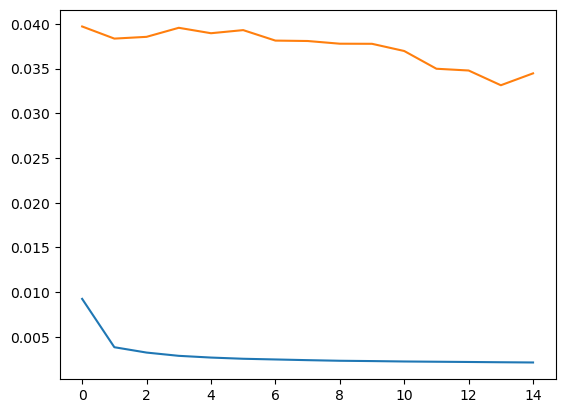

In [24]:
import seaborn as sns
sns.lineplot(train_losses)
sns.lineplot(val_losses)

In [ ]:
def train_lstm(X_train: pd.DataFrame, 
               y_train: pd.Series, 
               X_val: pd.DataFrame, 
               y_val: pd.Series, 
               num_trials: Optional[int|None]) -> tuple:
    """Entrainement d'un modèle LSTM sur X_train, y_train avec optimisation bayésienne optuna (n_trials pour le nombre d'essais). 
    Retourne la quantification de son erreur (best_rmse) et ses hyperparamètres optimaux (dict_best_params) sur un dataset de validation (X_val, y_val)

    Args:
        X_train (pd.DataFrame): Dataset d'entrainement
        y_train (pd.Series): Variable cible d'entrainement
        X_val (pd.DataFrame): Dataset de validation
        y_val (pd.Series): Variable cible de validation

    Returns:
        best_rmse, dict_best_params (tuple) : la quantification de son erreur (best_rmse) et ses hyperparamètres optimaux (dict_best_params)
    """
    # Initialisation
    best_rmse = np.inf
    dict_best_params = {}
    
    def objective_lstm(trial) -> np.float64 :
        """Prend en entrée un set d'hyperparamètres LightGBM issus du sampler d'Optuna, et retourne sa performance RMSE.

        Args:
            trial : Set d'hyperparamètres LightGBM

        Returns:
            rmse (np.float64): Racine carrée de l'erreur quadratique moyenne du modèle
        """
        # # HP
        # num_leaves = trial.suggest_int("num_leaves", 10, 100)
        # max_depth = trial.suggest_int("max_depth", 3, 15)
        # learning_rate = trial.suggest_float("learning_rate", 0.005, 0.2, log=True)
        # n_estimators = trial.suggest_int("n_estimators", 100, 1000)
        # min_child_samples = trial.suggest_int("min_child_samples", 10, 50)

        # # Model
        # model = lgb.LGBMRegressor(num_leaves=num_leaves, 
        #                         max_depth=max_depth, 
        #                         learning_rate=learning_rate,
        #                         n_estimators=n_estimators,
        #                         min_child_samples=min_child_samples, verbosity=-1,
        #                         random_state=42)
        
        # # Training
        # fitted_model = model.fit(X_train, y_train)
        # predictions = fitted_model.predict(X_val)
        # rmse = np.sqrt(mean_squared_error(y_val, predictions))

        #return rmse


    # Recherche des HP et prédictions
    study = optuna.create_study(direction="minimize")
    #study.optimize(objective_lightgbm, n_trials=num_trials, n_jobs=-1)
    
    # Set optimal score/HP
    dict_best_params = study.best_params
    best_rmse = study.best_value

    return best_rmse, dict_best_params